In [ ]:
import torch.nn.functional as F
from typing import List, Tuple
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import os
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Read dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alexanderyyy/mnist-png")

print("Path to dataset files:", path)

/home/nakbari/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/nakbari/.cache/kagglehub/datasets/alexanderyyy/mnist-png/versions/1


In [3]:
training_folder_path = f'{path}/mnist_png/train';
testing_folder_path = f'{path}/mnist_png/test';

T = 200  # Total simulation time
dt = 0.2  # Simulation time step
nt = round(T / dt)  # Total simulation steps
time = np.linspace(0, T, nt)

In [4]:
np.random.seed(8)
torch.manual_seed(8)

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

rf_data_test = []
rf_data_train = []

for digit in range(10):
    digit_folder_path = os.path.join(testing_folder_path, str(digit))
    files = sorted([os.path.join(digit_folder_path, f) for f in os.listdir(digit_folder_path)])
    for file_path in files:
        image = Image.open(file_path)
        image = transform(image) 
        rf_data_test.append({'Value': image, 'Label': digit})

    digit_folder_path = os.path.join(training_folder_path, str(digit))
    files = sorted([os.path.join(digit_folder_path, f) for f in os.listdir(digit_folder_path)])
    for file_path in files:
        image = Image.open(file_path)
        image = transform(image).squeeze(0)
        rf_data_train.append({'Value': image, 'Label': digit})

print("Test Size: ", len(rf_data_test))
print("Train size: ", len(rf_data_train))

Test Size:  10000
Train size:  60000


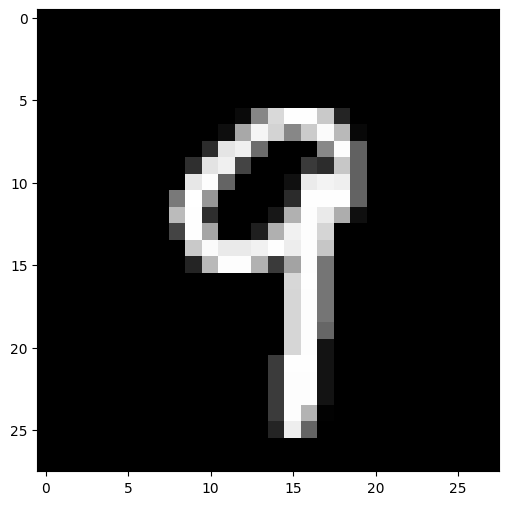

In [5]:
plt.figure(figsize=(10,6))
plt.imshow(image, cmap='gray')

plt.show()

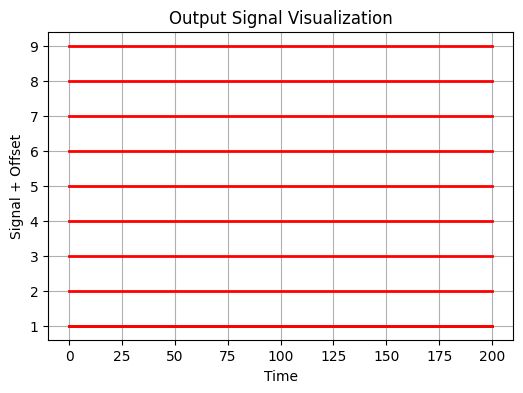

In [6]:
output_signals = []

for i in range(10):
    signal = np.zeros((nt, 10))
    signal[:, i] = 1
    output_signals.append(signal)

plt.figure(figsize=(6, 4))

for j in range(10):
    label = rf_data_train[11]['Label']
    plt.plot(time, output_signals[label][:, j] + j, 'r', linewidth=2)

plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Signal + Offset')
plt.title('Output Signal Visualization')
plt.show()

In [7]:
train_values = np.array([item['Value'] for item in rf_data_train])
train_labels = np.array([item['Label'] for item in rf_data_train])

test_values = np.array([item['Value'] for item in rf_data_test])
test_labels = np.array([item['Label'] for item in rf_data_test])

train_values_tensor = torch.tensor(train_values, dtype=torch.float32)  # Spike trains
train_labels_tensor = torch.tensor(train_labels, dtype=torch.int)  # Labels
test_values_tensor = torch.tensor(test_values, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.int)

output_signals_tensor = torch.stack([torch.tensor(signal, dtype=torch.float32) for signal in output_signals])


print(train_values_tensor.shape)
print(train_labels_tensor.shape)
print(test_values_tensor.shape)
print(test_labels_tensor.shape)
print(output_signals_tensor.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])
torch.Size([10, 1000, 10])


In [8]:
np.random.seed(8)
torch.manual_seed(8)

batch_size = 200
train_dataloader = DataLoader(TensorDataset(train_values_tensor, train_labels_tensor), batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(TensorDataset(test_values_tensor, test_labels_tensor), batch_size=batch_size, shuffle=True)

In [9]:
train_values_tensor = train_values_tensor.to(device)
train_labels_tensor = train_labels_tensor.to(device)
output_signals_tensor = output_signals_tensor.to(device)

## ML-SNN Model

In [ ]:
@torch.jit.script
def compute_output(s_e: torch.Tensor, s_i: torch.Tensor, weight: torch.Tensor, bias: torch.Tensor) -> torch.Tensor:
    cat = torch.cat([s_e, s_i], 1)
    return F.linear(cat, weight, bias)

@torch.jit.script
def compute_derivatives(
    V_e: torch.Tensor, n_e: torch.Tensor, s_e: torch.Tensor,
    V_i: torch.Tensor, n_i: torch.Tensor, s_i: torch.Tensor,
    I_e: torch.Tensor, I_i: torch.Tensor,
    omega_ee: torch.Tensor, omega_ei: torch.Tensor, 
    omega_ie: torch.Tensor, omega_ii: torch.Tensor,
    V1: float, V2: float, V3: float, V4: float,
    T_max: float, V_t: float, K_p: float,
    g_Ca: float, V_Ca: float, g_K: float, V_K: float, g_L: float, V_L: float,
    phi: float, ar_e: float, ad_e: float, ar_i: float, ad_i: float,
    gbar_e: float, gbar_i: float, E_ampa: float, E_gaba: float,
    Cm: float
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    m_inf_e = 0.5 * (1 + torch.tanh((V_e - V1) / V2))
    n_inf_e = 0.5 * (1 + torch.tanh((V_e - V3) / V4))
    tau_n_e = 1.0 / torch.cosh((V_e - V3) / (2 * V4))
    TM_e = T_max / (1 + torch.exp(-(V_e - V_t) / K_p))
    
    m_inf_i = 0.5 * (1 + torch.tanh((V_i - V1) / V2))
    n_inf_i = 0.5 * (1 + torch.tanh((V_i - V3) / V4))
    tau_n_i = 1.0 / torch.cosh((V_i - V3) / (2 * V4))
    TM_i = T_max / (1 + torch.exp(-(V_i - V_t) / K_p))
    
    I_syn_e = (gbar_e * torch.mm(s_e, omega_ee.transpose(0,1)) * (V_e - E_ampa) +
               gbar_i * torch.mm(s_i, omega_ei.transpose(0,1)) * (V_e - E_gaba))
    I_syn_i = (gbar_e * torch.mm(s_e, omega_ie.transpose(0,1)) * (V_i - E_ampa) +
               gbar_i * torch.mm(s_i, omega_ii.transpose(0,1)) * (V_i - E_gaba))
    
    dV_e = (I_e - g_L*(V_e - V_L) - g_K*n_e*(V_e - V_K) - g_Ca*m_inf_e*(V_e - V_Ca) - I_syn_e) / Cm
    dn_e = phi*(n_inf_e - n_e) / tau_n_e
    ds_e = ar_e * TM_e * (1.0 - s_e) - ad_e * s_e
    
    dV_i = (I_i - g_L*(V_i - V_L) - g_K*n_i*(V_i - V_K) - g_Ca*m_inf_i*(V_i - V_Ca) - I_syn_i) / Cm
    dn_i = phi*(n_inf_i - n_i) / tau_n_i
    ds_i = ar_i * TM_i * (1.0 - s_i) - ad_i * s_i
    
    return dV_e, dn_e, ds_e, dV_i, dn_i, ds_i

@torch.jit.script
def rk4_step(
    V_e: torch.Tensor, n_e: torch.Tensor, s_e: torch.Tensor,
    V_i: torch.Tensor, n_i: torch.Tensor, s_i: torch.Tensor,
    I_e: torch.Tensor, I_i: torch.Tensor, dt: float,
    omega_ee: torch.Tensor, omega_ei: torch.Tensor, 
    omega_ie: torch.Tensor, omega_ii: torch.Tensor,
    V1: float, V2: float, V3: float, V4: float,
    T_max: float, V_t: float, K_p: float,
    g_Ca: float, V_Ca: float, g_K: float, V_K: float, g_L: float, V_L: float,
    phi: float, ar_e: float, ad_e: float, ar_i: float, ad_i: float,
    gbar_e: float, gbar_i: float, E_ampa: float, E_gaba: float,
    Cm: float
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    k1 = compute_derivatives(V_e, n_e, s_e, V_i, n_i, s_i, I_e, I_i,
                             omega_ee, omega_ei, omega_ie, omega_ii,
                             V1, V2, V3, V4, T_max, V_t, K_p,
                             g_Ca, V_Ca, g_K, V_K, g_L, V_L,
                             phi, ar_e, ad_e, ar_i, ad_i,
                             gbar_e, gbar_i, E_ampa, E_gaba, Cm)
    V_e_k2 = V_e + 0.5 * dt * k1[0]
    n_e_k2 = n_e + 0.5 * dt * k1[1]
    s_e_k2 = s_e + 0.5 * dt * k1[2]
    V_i_k2 = V_i + 0.5 * dt * k1[3]
    n_i_k2 = n_i + 0.5 * dt * k1[4]
    s_i_k2 = s_i + 0.5 * dt * k1[5]
    k2 = compute_derivatives(V_e_k2, n_e_k2, s_e_k2, V_i_k2, n_i_k2, s_i_k2, I_e, I_i,
                             omega_ee, omega_ei, omega_ie, omega_ii,
                             V1, V2, V3, V4, T_max, V_t, K_p,
                             g_Ca, V_Ca, g_K, V_K, g_L, V_L,
                             phi, ar_e, ad_e, ar_i, ad_i,
                             gbar_e, gbar_i, E_ampa, E_gaba, Cm)
    V_e_k3 = V_e + 0.5 * dt * k2[0]
    n_e_k3 = n_e + 0.5 * dt * k2[1]
    s_e_k3 = s_e + 0.5 * dt * k2[2]
    V_i_k3 = V_i + 0.5 * dt * k2[3]
    n_i_k3 = n_i + 0.5 * dt * k2[4]
    s_i_k3 = s_i + 0.5 * dt * k2[5]
    k3 = compute_derivatives(V_e_k3, n_e_k3, s_e_k3, V_i_k3, n_i_k3, s_i_k3, I_e, I_i,
                             omega_ee, omega_ei, omega_ie, omega_ii,
                             V1, V2, V3, V4, T_max, V_t, K_p,
                             g_Ca, V_Ca, g_K, V_K, g_L, V_L,
                             phi, ar_e, ad_e, ar_i, ad_i,
                             gbar_e, gbar_i, E_ampa, E_gaba, Cm)
    V_e_k4 = V_e + dt * k3[0]
    n_e_k4 = n_e + dt * k3[1]
    s_e_k4 = s_e + dt * k3[2]
    V_i_k4 = V_i + dt * k3[3]
    n_i_k4 = n_i + dt * k3[4]
    s_i_k4 = s_i + dt * k3[5]
    k4 = compute_derivatives(V_e_k4, n_e_k4, s_e_k4, V_i_k4, n_i_k4, s_i_k4, I_e, I_i,
                             omega_ee, omega_ei, omega_ie, omega_ii,
                             V1, V2, V3, V4, T_max, V_t, K_p,
                             g_Ca, V_Ca, g_K, V_K, g_L, V_L,
                             phi, ar_e, ad_e, ar_i, ad_i,
                             gbar_e, gbar_i, E_ampa, E_gaba, Cm)
    V_e_new = V_e + (dt/6.0) * (k1[0] + 2*k2[0] + 2*k3[0] + k4[0])
    n_e_new = n_e + (dt/6.0) * (k1[1] + 2*k2[1] + 2*k3[1] + k4[1])
    s_e_new = s_e + (dt/6.0) * (k1[2] + 2*k2[2] + 2*k3[2] + k4[2])
    V_i_new = V_i + (dt/6.0) * (k1[3] + 2*k2[3] + 2*k3[3] + k4[3])
    n_i_new = n_i + (dt/6.0) * (k1[4] + 2*k2[4] + 2*k3[4] + k4[4])
    s_i_new = s_i + (dt/6.0) * (k1[5] + 2*k2[5] + 2*k3[5] + k4[5])
    return V_e_new, n_e_new, s_e_new, V_i_new, n_i_new, s_i_new


@torch.jit.script
def integrate_chunk_with_output(
    input: torch.Tensor,  
    chunk_size: int,
    init_V_e: torch.Tensor, init_n_e: torch.Tensor, init_s_e: torch.Tensor,
    init_V_i: torch.Tensor, init_n_i: torch.Tensor, init_s_i: torch.Tensor,
    dt: float, I: float,
    omega_ee: torch.Tensor, omega_ei: torch.Tensor, 
    omega_ie: torch.Tensor, omega_ii: torch.Tensor,
    V1: float, V2: float, V3: float, V4: float,
    T_max: float, V_t: float, K_p: float,
    g_Ca: float, V_Ca: float, g_K: float, V_K: float, g_L: float, V_L: float,
    phi: float, ar_e: float, ad_e: float, ar_i: float, ad_i: float,
    gbar_e: float, gbar_i: float, E_ampa: float, E_gaba: float,
    Cm: float,
    proj_weight: torch.Tensor, proj_bias: torch.Tensor,
    out_weight: torch.Tensor, out_bias: torch.Tensor
) -> Tuple[torch.Tensor, 
           Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor], 
           Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]]:
    steps = chunk_size
    batch_size = input.size(0)
    
    # Initialize states:
    V_e, n_e, s_e = init_V_e, init_n_e, init_s_e
    V_i, n_i, s_i = init_V_i, init_n_i, init_s_i

    outputs = []
    
    V_e_list = torch.jit.annotate(List[torch.Tensor], [])
    n_e_list = torch.jit.annotate(List[torch.Tensor], [])
    s_e_list = torch.jit.annotate(List[torch.Tensor], [])
    V_i_list = torch.jit.annotate(List[torch.Tensor], [])
    n_i_list = torch.jit.annotate(List[torch.Tensor], [])
    s_i_list = torch.jit.annotate(List[torch.Tensor], [])

    projected_input = 80 * torch.tanh(F.linear(input, proj_weight, proj_bias) + I)
    NE = V_e.size(1)
    I_e = projected_input[:, :NE]
    I_i = projected_input[:, NE:]
    
    for t in range(steps):       

        # Perform one RK4 step with current input:
        V_e, n_e, s_e, V_i, n_i, s_i = rk4_step(
            V_e, n_e, s_e, V_i, n_i, s_i, I_e, I_i, dt,
            omega_ee, omega_ei, omega_ie, omega_ii,
            V1, V2, V3, V4, T_max, V_t, K_p,
            g_Ca, V_Ca, g_K, V_K, g_L, V_L,
            phi, ar_e, ad_e, ar_i, ad_i,
            gbar_e, gbar_i, E_ampa, E_gaba, Cm
        )
        # Compute output for this time step using the output layer:
        out = compute_output(s_e, s_i, out_weight, out_bias)
        outputs.append(out)
        
        V_e_list.append(V_e[0].clone())
        n_e_list.append(n_e[0].clone())
        s_e_list.append(s_e[0].clone())
        V_i_list.append(V_i[0].clone())
        n_i_list.append(n_i[0].clone())
        s_i_list.append(s_i[0].clone())

    outputs_tensor = torch.stack(outputs, dim=0)
    final_states = (V_e, n_e, s_e, V_i, n_i, s_i)
    all_states = (torch.stack(V_e_list, dim=0),
                  torch.stack(n_e_list, dim=0),
                  torch.stack(s_e_list, dim=0),
                  torch.stack(V_i_list, dim=0),
                  torch.stack(n_i_list, dim=0),
                  torch.stack(s_i_list, dim=0))
    return outputs_tensor, final_states, all_states

# --------------------------------------------------------------------
# Morris-Lecar SNN Model
# --------------------------------------------------------------------
class MorrisLecarSNN(nn.Module):
    def __init__(self, input_size, output_size, chunk_size, NE=250, NI=250, dt=0.1,
                 Cm=20.0, g_Ca=4.0, g_K=8.0, g_L=2.0, V_Ca=120.0, V_K=-84.0, V_L=-60.0,
                 phi=0.067, V1=-1.2, V2=18.0, V3=12.0, V4=17.4, ar_e=3.0, ad_e=0.1,
                 ar_i=3.0, ad_i=0.1, T_max=1.0, V_t=2.0, K_p=5.0, gbar_e=1.0, gbar_i=1.0,
                 E_ampa=0.0, E_gaba=-75.0, I=0.0):
        super(MorrisLecarSNN, self).__init__()
        self.NE = NE
        self.NI = NI
        self.dt = dt
        self.hidden_size = NE + NI
        self.chunk_size = chunk_size

        # Model parameters
        self.I = I
        self.Cm = Cm
        self.g_Ca = g_Ca
        self.g_K = g_K
        self.g_L = g_L
        self.V_Ca = V_Ca
        self.V_K = V_K
        self.V_L = V_L
        self.phi = phi
        self.V1 = V1
        self.V2 = V2
        self.V3 = V3
        self.V4 = V4
        self.ar_e = ar_e
        self.ad_e = ad_e
        self.ar_i = ar_i
        self.ad_i = ad_i
        self.T_max = T_max
        self.V_t = V_t
        self.K_p = K_p
        self.gbar_e = gbar_e
        self.gbar_i = gbar_i
        self.E_ampa = E_ampa
        self.E_gaba = E_gaba

        # Input layer
        self.input_projection = nn.Linear(input_size, self.hidden_size)
        
        # Synaptic weights
        self.omega_ee_raw = nn.Parameter(torch.randn(NE, NE, device=device))
        self.omega_ei_raw = nn.Parameter(torch.randn(NE, NE, device=device))
        self.omega_ie_raw = nn.Parameter(torch.randn(NE, NE, device=device))
        self.omega_ii_raw = nn.Parameter(torch.randn(NE, NE, device=device))
        
        # Upper bound
        self.upper_bound = 1 / math.sqrt(self.hidden_size)

        # Output layer
        self.output_layer = nn.Linear(self.hidden_size, output_size)

        # State storage (if needed)
        self.store_states = False
        self._storage = None
        self._storage_idx = 0
    
    # Property to get bounded omega matrices
    @property
    def omega_ee(self):
        return torch.sigmoid(self.omega_ee_raw) * self.upper_bound
    
    @property
    def omega_ei(self):
        return torch.sigmoid(self.omega_ei_raw) * self.upper_bound
    
    @property
    def omega_ie(self):
        return torch.sigmoid(self.omega_ie_raw) * self.upper_bound
    
    @property
    def omega_ii(self):
        return torch.sigmoid(self.omega_ii_raw) * self.upper_bound
    
    def _init_storage(self, total_steps: int):
        device = self.input_projection.weight.device
        self._storage = {
            'V_e': torch.zeros(total_steps, self.NE, device=device),
            'n_e': torch.zeros(total_steps, self.NE, device=device),
            's_e': torch.zeros(total_steps, self.NE, device=device),
            'V_i': torch.zeros(total_steps, self.NI, device=device),
            'n_i': torch.zeros(total_steps, self.NI, device=device),
            's_i': torch.zeros(total_steps, self.NI, device=device)
        }
        self._storage_idx = 0

    def enable_storage(self, total_steps: int):
        self.store_states = True
        self._init_storage(total_steps)

    def disable_storage(self):
        self.store_states = False
        self._storage = None
        self._storage_idx = 0

    def get_storage(self):
        return self._storage

    def _init_states(self, batch_size: int):
        device = self.input_projection.weight.device
        V_e = 30 * torch.rand((batch_size, self.NE), device=device)
        n_e = torch.rand((batch_size, self.NE), device=device)
        s_e = torch.zeros((batch_size, self.NE), device=device)
        V_i = -50 + 30 * torch.rand((batch_size, self.NI), device=device)
        n_i = torch.rand((batch_size, self.NI), device=device)
        s_i = torch.zeros((batch_size, self.NI), device=device)
        return (V_e, n_e, s_e, V_i, n_i, s_i)

    def forward(self, input, states=None):
        """
        x_sequence: [batch_size, seq_len, input_size]
        For each time step, we require the output.
        We process the sequence in chunks using our scripted integration function.
        """
        batch_size, _ = input.shape
        outputs_list = []

        if states is None:
            states = self._init_states(batch_size)
        
        # We need to get the projection and output layer parameters.
        proj_weight = self.input_projection.weight
        proj_bias = self.input_projection.bias
        out_weight = self.output_layer.weight
        out_bias = self.output_layer.bias

        # Call the scripted integration function that returns outputs for each step in the chunk.
        chunk_outputs, states, all_states = integrate_chunk_with_output(
            input, self.chunk_size, states[0], states[1], states[2],
            states[3], states[4], states[5],
            self.dt, self.I,
            self.omega_ee, self.omega_ei, self.omega_ie, self.omega_ii,
            self.V1, self.V2, self.V3, self.V4,
            self.T_max, self.V_t, self.K_p,
            self.g_Ca, self.V_Ca, self.g_K, self.V_K, self.g_L, self.V_L,
            self.phi, self.ar_e, self.ad_e, self.ar_i, self.ad_i,
            self.gbar_e, self.gbar_i, self.E_ampa, self.E_gaba,
            self.Cm,
            proj_weight, proj_bias,
            out_weight, out_bias
        )
       
        chunk_outputs = chunk_outputs.transpose(0, 1)
        outputs_list.append(chunk_outputs)
        if self.store_states:
            steps = self.chunk_size
            with torch.no_grad():
                self._storage['V_e'][self._storage_idx:self._storage_idx + steps] = all_states[0]
                self._storage['n_e'][self._storage_idx:self._storage_idx + steps] = all_states[1]
                self._storage['s_e'][self._storage_idx:self._storage_idx + steps] = all_states[2]
                self._storage['V_i'][self._storage_idx:self._storage_idx + steps] = all_states[3]
                self._storage['n_i'][self._storage_idx:self._storage_idx + steps] = all_states[4]
                self._storage['s_i'][self._storage_idx:self._storage_idx + steps] = all_states[5]
                self._storage_idx += steps
        outputs = torch.cat(outputs_list, dim=1)
        return outputs, states

    def warmup(self, input, states=None):
        """
        x_sequence: [batch_size, seq_len, input_size]
        For each time step, we require the output.
        We process the sequence in chunks using our scripted integration function.
        """
        with torch.no_grad():
            batch_size, _ = input.shape
            outputs_list = []
    
            if states is None:
                states = self._init_states(batch_size)
            
            # We need to get the projection and output layer parameters.
            proj_weight = self.input_projection.weight
            proj_bias = self.input_projection.bias
            out_weight = self.output_layer.weight
            out_bias = self.output_layer.bias

            # Call the scripted integration function that returns outputs for each step in the chunk.
            _, states, _ = integrate_chunk_with_output(
                input, self.chunk_size, states[0], states[1], states[2],
                states[3], states[4], states[5],
                self.dt, self.I,
                self.omega_ee, self.omega_ei, self.omega_ie, self.omega_ii,
                self.V1, self.V2, self.V3, self.V4,
                self.T_max, self.V_t, self.K_p,
                self.g_Ca, self.V_Ca, self.g_K, self.V_K, self.g_L, self.V_L,
                self.phi, self.ar_e, self.ad_e, self.ar_i, self.ad_i,
                self.gbar_e, self.gbar_i, self.E_ampa, self.E_gaba,
                self.Cm,
                proj_weight, proj_bias,
                out_weight, out_bias
            )
           
        return states


    def plot_full_state(self, num_neurons=5, neuron_offset=2.0, figure_name=""):
        if not self.store_states or self._storage is None:
            print("Storage not enabled or no data stored!")
            return
        
        store = {k: v.cpu().numpy() for k, v in self._storage.items()}
        time_steps = store['V_e'].shape[0]
        time = np.arange(0, time_steps) * self.dt

        fig = plt.figure(figsize=(18, 12))
        plt.suptitle("Neuronal State Dynamics (T=100s)", fontsize=16)
        gs = fig.add_gridspec(3, 2)
        axs = {
            'V_e': fig.add_subplot(gs[0, 0]),
            'V_i': fig.add_subplot(gs[0, 1]),
            'n_e': fig.add_subplot(gs[1, 0]),
            'n_i': fig.add_subplot(gs[1, 1]),
            's_e': fig.add_subplot(gs[2, 0]),
            's_i': fig.add_subplot(gs[2, 1])
        }

        rand_e = np.random.choice(self.NE, num_neurons, replace=False)
        rand_i = np.random.choice(self.NI, num_neurons, replace=False)

        for idx, n in enumerate(rand_e):
            offset = idx * neuron_offset
            axs['V_e'].plot(time, (store['V_e'][:, n]) / 150 + offset, label=f'Neuron {n}')
            axs['n_e'].plot(time, store['n_e'][:, n] + offset)
            axs['s_e'].plot(time, store['s_e'][:, n] + offset)

        for idx, n in enumerate(rand_i):
            offset = idx * neuron_offset
            axs['V_i'].plot(time, (store['V_i'][:, n]) / 150 + offset, label=f'Neuron {n}')
            axs['n_i'].plot(time, store['n_i'][:, n] + offset)
            axs['s_i'].plot(time, store['s_i'][:, n] + offset)

        titles = {
            'V_e': "Excitatory Membrane Potentials",
            'V_i': "Inhibitory Membrane Potentials",
            'n_e': "Excitatory Gating Variables",
            'n_i': "Inhibitory Gating Variables",
            's_e': "Excitatory Synaptic Variables",
            's_i': "Inhibitory Synaptic Variables"
        }
        for key, ax in axs.items():
            ax.set_title(titles[key])
            ax.set_xlabel("Time (s)")
            ax.grid(True, alpha=0.3)
            if key in ['V_e', 'V_i']:
                ax.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        if figure_name:
            plt.savefig(figure_name, bbox_inches='tight')
        plt.show()

## Initialize the model and training parameters

In [11]:
np.random.seed(8)
torch.manual_seed(8)

chunk_size = 100
epochs = 5
states = None

NE = 500
NI = 500

model = MorrisLecarSNN(input_size=28*28, output_size=10, chunk_size=chunk_size, NE=NE, NI=NI, dt=dt).to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

criterion = nn.CrossEntropyLoss()

initial_state_path = 'MNIST-initial.pth'
final_state_path = 'MNIST-final.pth'

torch.save(model.state_dict(), initial_state_path)
print(f"Initial model state saved to {initial_state_path}")

Initial model state saved to MNIST-initial.pth


## Training

In [ ]:
%%time

np.random.seed(8)
torch.manual_seed(8)

progress_interval = 0.04

warmup_duration = 200
epoch_has_nan = False

# Training loop
for epoch in range(epochs):
    model.train()
    loss = 0
    total_right = 0
    batch_right = 0
    total_loss = 0
    batch_loss = 0

    num_batches = len(train_dataloader)
    progress_step = int(progress_interval * num_batches) 

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        input_seq = images.view(batch_size, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        states = None 
        outputs_list = []
        
        with torch.no_grad():
            states = model.warmup(torch.zeros(batch_size, 28*28).to(device), states)        

        # Process the sequence in TBPTT chunks
        for start in range(0, nt, chunk_size):
            
            chunk_outputs, states = model(input_seq, states)
            avg_outputs = torch.mean(chunk_outputs, dim=1)
            loss = criterion(avg_outputs, labels.long())

            loss.backward()
            batch_loss += loss.detach().item()
            total_loss += loss.detach().item()
            outputs_list.append(chunk_outputs.detach())

            if states is not None:
                states = tuple(s.detach() for s in states)

        optimizer.step()

        outputs = torch.cat(outputs_list, dim=1)
        avg_outputs = torch.mean(outputs, dim=1) 
        predictions = torch.argmax(avg_outputs, dim=1)

        correct_predictions = (predictions == labels).sum().item()

        batch_right += correct_predictions
        total_right += correct_predictions

        if (batch_idx + 1) % progress_step == 0 or (batch_idx + 1) == num_batches:
            print(f"Epoch: {epoch+1}/{epochs}, "
                  f"Progress: {100 * (batch_idx + 1) / num_batches:.2f}%, "
                  f"BatchLoss: {batch_loss:.4f}, "
                  f"BatchAccuracy: {batch_right / (batch_size * num_batches * progress_interval):.4f}, "
                  f"TotalAccuracy: {total_right / len(train_dataloader.dataset):.4f}")
            batch_loss = 0
            batch_right = 0
    
    print(f"Epoch: {epoch+1}, TotalLoss: {total_loss:.4f}, "
        f"Accuracy: {total_right / len(train_dataloader.dataset):.4f}")

checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}

torch.save(checkpoint, final_state_path)
print("Model and optimizer state saved successfully!")

Epoch: 1/5, Progress: 4.00%, BatchLoss: 203.4523, BatchAccuracy: 0.6162, TotalAccuracy: 0.0246
Epoch: 1/5, Progress: 8.00%, BatchLoss: 104.1989, BatchAccuracy: 0.8342, TotalAccuracy: 0.0580
Epoch: 1/5, Progress: 12.00%, BatchLoss: 68.5518, BatchAccuracy: 0.8812, TotalAccuracy: 0.0933
Epoch: 1/5, Progress: 16.00%, BatchLoss: 53.1463, BatchAccuracy: 0.9008, TotalAccuracy: 0.1293
Epoch: 1/5, Progress: 20.00%, BatchLoss: 45.9371, BatchAccuracy: 0.9004, TotalAccuracy: 0.1653
Epoch: 1/5, Progress: 24.00%, BatchLoss: 40.7101, BatchAccuracy: 0.9154, TotalAccuracy: 0.2019
Epoch: 1/5, Progress: 28.00%, BatchLoss: 39.5597, BatchAccuracy: 0.9179, TotalAccuracy: 0.2387
Epoch: 1/5, Progress: 32.00%, BatchLoss: 37.1136, BatchAccuracy: 0.9246, TotalAccuracy: 0.2756
Epoch: 1/5, Progress: 36.00%, BatchLoss: 36.7255, BatchAccuracy: 0.9183, TotalAccuracy: 0.3124
Epoch: 1/5, Progress: 40.00%, BatchLoss: 33.9050, BatchAccuracy: 0.9237, TotalAccuracy: 0.3493
Epoch: 1/5, Progress: 44.00%, BatchLoss: 31.9045, 

In [13]:
checkpoint = torch.load(final_state_path, map_location=device)

model = MorrisLecarSNN(input_size=28*28, output_size=10, chunk_size=chunk_size, NE=500, NI=500, dt=dt).to(device)

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Testing

In [ ]:
np.random.seed(8)
torch.manual_seed(8)

model.eval()

total_loss = 0
total_correct = 0
num_samples = 0
warmup_duration = 200
model.disable_storage()
model.enable_storage(total_steps=nt)
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_dataloader:
        input = images.view(batch_size, 28*28).to(device)
        labels = labels.to(device)

        states = None  
        outputs_list = []
        model._storage_idx = 0 

        with torch.no_grad():
            states = model.warmup(torch.zeros(batch_size, 28*28).to(device), states)   

        
        for start in range(0, nt, chunk_size):
            chunk_outputs, states = model(input, states)
            avg_outputs = torch.mean(chunk_outputs, dim=1)  
            total_loss = criterion(avg_outputs, labels.long()).item()

            outputs_list.append(chunk_outputs)

            if states is not None:
                states = tuple(s.detach() for s in states)

        outputs = torch.cat(outputs_list, dim=1)
        avg_outputs = torch.mean(outputs, dim=1)  
        predictions = torch.argmax(avg_outputs, dim=1)

        # Compute accuracy
        total_correct += (predictions == labels).sum().item()
        num_samples += labels.size(0)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())


# Compute final metrics
avg_loss = total_loss / len(test_dataloader)
accuracy = total_correct / num_samples

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
data = model.get_storage()

Test Loss: 0.0014, Test Accuracy: 0.9774


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Calculate overall accuracy from the confusion matrix
overall_accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
print(f"\nOverall Test Accuracy (from Confusion Matrix): {overall_accuracy:.4f}")
class_names = [str(i) for i in range(10)] # Assuming 10 classes (0-9)

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_names))



Confusion Matrix:
[[ 975    0    1    1    0    1    0    1    1    0]
 [   0 1120    3    2    0    1    4    1    3    1]
 [   5    0 1009    1    1    0    2    7    6    1]
 [   0    0    0  988    0    8    0    6    3    5]
 [   3    0    1    1  931    0    5    1    2   38]
 [   3    0    0    3    1  872    4    1    3    5]
 [   7    3    1    1    1    4  938    1    2    0]
 [   1    5    6    1    0    0    0 1005    2    8]
 [   8    0    1    3    4    4    3    3  944    4]
 [   3    2    0    5    3    2    0    2    0  992]]

Overall Test Accuracy (from Confusion Matrix): 0.9774

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.95      0.97       982
           5       0.98      0.98      0.98   